# Algoritmo Newton-Bernstein para Flujo Turbulento de Capa Límite

## Evaluación de Robustez Numérica Bajo Mal Condicionamiento

### Análisis comparativo de métodos de interpolación en condiciones de alto número de Reynolds (Re_τ = 2000)

Este notebook implementa un análisis exhaustivo del algoritmo Newton-Bernstein aplicado a la interpolación de perfiles de velocidad en capa límite turbulenta, comparándolo contra métodos clásicos (Vandermonde, Lagrange baricéntrica, Spline cúbica) bajo cuatro escenarios de mal condicionamiento.

In [9]:
# Imports y configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import BarycentricInterpolator, CubicSpline
from scipy.linalg import solve
from time import perf_counter
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## Sección 1: Configuración del Problema Físico

### 1.1 Caso de Estudio: Capa Límite Turbulenta

**Problema seleccionado**: Perfil de velocidad en capa límite turbulenta sobre placa plana con alto número de Reynolds.

**Justificación del mal condicionamiento**:
- Gradientes muy pronunciados cerca de la pared
- Nodos de medición deben concentrarse en región viscosa
- Matrices de interpolación tienen números de condición κ > 10¹⁰

### 1.2 Ley de Pared (Perfil Analítico Exacto)

$$u^+(y^+) = \begin{cases}
y^+ & y^+ < 5 \text{ (subcapa viscosa)} \\
\frac{1}{\kappa}\ln(y^+) + C & y^+ > 30 \text{ (capa logarítmica)} \\
\text{transición suave} & 5 \leq y^+ \leq 30
\end{cases}$$

Donde:
- $u^+ = u/u_{\tau}$ (velocidad adimensional)
- $y^+ = yu_{\tau}/\nu$ (distancia adimensional)
- $\kappa = 0.41$ (constante de von Kármán)
- $C = 5.0$

In [10]:
# Parámetros físicos del experimento
Re_tau = 2000          # Número de Reynolds basado en velocidad de fricción
nu = 1.5e-5            # Viscosidad cinemática del aire (m²/s)
u_tau = 0.5            # Velocidad de fricción (m/s)
delta = Re_tau * nu / u_tau  # Espesor de capa límite (m)

print("="*70)
print("PARÁMETROS FÍSICOS DEL PROBLEMA")
print("="*70)
print(f"Número de Reynolds: Re_τ = {Re_tau}")
print(f"Viscosidad cinemática: ν = {nu:.2e} m²/s")
print(f"Velocidad de fricción: u_τ = {u_tau} m/s")
print(f"Espesor capa límite: δ = {delta*1000:.2f} mm")

# Parámetros de interpolación
n_values = [15, 20, 25, 30, 35, 40]  # Grados a probar
escenarios = ['A', 'B', 'C', 'D']
metodos_interpol = ['NB', 'Vand', 'Lagr', 'Spline']

print(f"\nGrados a evaluar: {n_values}")
print(f"Escenarios: {escenarios}")
print(f"Métodos: {metodos_interpol}")

PARÁMETROS FÍSICOS DEL PROBLEMA
Número de Reynolds: Re_τ = 2000
Viscosidad cinemática: ν = 1.50e-05 m²/s
Velocidad de fricción: u_τ = 0.5 m/s
Espesor capa límite: δ = 60.00 mm

Grados a evaluar: [15, 20, 25, 30, 35, 40]
Escenarios: ['A', 'B', 'C', 'D']
Métodos: ['NB', 'Vand', 'Lagr', 'Spline']


In [11]:
def perfil_velocidad_exacto(y, u_tau, nu, kappa=0.41, C=5.0):
    """
    Calcula el perfil de velocidad según ley de pared con 3 regiones.
    
    Parameters:
    -----------
    y : array_like
        Coordenadas normales a la pared (m)
    u_tau : float
        Velocidad de fricción (m/s)
    nu : float
        Viscosidad cinemática (m²/s)
    kappa : float
        Constante de von Kármán (default 0.41)
    C : float
        Constante logarítmica (default 5.0)
    
    Returns:
    --------
    u : ndarray
        Velocidad dimensional (m/s)
    """
    y_plus = y * u_tau / nu
    u_plus = np.zeros_like(y_plus)
    
    # Subcapa viscosa (y+ < 5)
    mask_visc = y_plus < 5
    u_plus[mask_visc] = y_plus[mask_visc]
    
    # Capa logarítmica (y+ > 30)
    mask_log = y_plus > 30
    u_plus[mask_log] = (1/kappa) * np.log(y_plus[mask_log]) + C
    
    # Región de transición (5 <= y+ <= 30)
    mask_trans = ~mask_visc & ~mask_log
    if np.any(mask_trans):
        y_plus_trans = y_plus[mask_trans]
        # Interpolación suave entre subcapa y log
        f = (y_plus_trans - 5) / 25  # Factor [0,1]
        u_visc = y_plus_trans
        u_log = (1/kappa) * np.log(y_plus_trans) + C
        u_plus[mask_trans] = (1 - f) * u_visc + f * u_log
    
    # Convertir a velocidad dimensional
    u = u_plus * u_tau
    return u

# Test: Evaluar el perfil en algunos puntos
y_test = np.array([0, 1e-4, 5e-3, 0.01, 0.05])
u_test = perfil_velocidad_exacto(y_test, u_tau, nu)
y_plus_test = y_test * u_tau / nu

print("\n" + "="*70)
print("TEST: Perfil de Velocidad Exacto")
print("="*70)
print(f"{'y (m)':>12} {'y+ (dim)':>12} {'u (m/s)':>12} {'Región':>15}")
print("-"*70)
for i, (y, yp, u) in enumerate(zip(y_test, y_plus_test, u_test)):
    if yp < 5:
        region = "Viscosa"
    elif yp > 30:
        region = "Logarítmica"
    else:
        region = "Transición"
    print(f"{y:12.4e} {yp:12.4f} {u:12.6f} {region:>15}")

print("✓ Función perfil_velocidad_exacto() definida")


TEST: Perfil de Velocidad Exacto
       y (m)     y+ (dim)      u (m/s)          Región
----------------------------------------------------------------------
  0.0000e+00       0.0000     0.000000         Viscosa
  1.0000e-04       3.3333     1.666667         Viscosa
  5.0000e-03     166.6667     8.739019     Logarítmica
  1.0000e-02     333.3333     9.584321     Logarítmica
  5.0000e-02    1666.6667    11.547050     Logarítmica
✓ Función perfil_velocidad_exacto() definida


## Sección 2: Generación de Datos Sintéticos

### 2.1 Cuatro Escenarios de Mal Condicionamiento

| Escenario | Distribución | Perturbación | Número de Condición Esperado | Desafío |
|-----------|-------------|-------------|-----|-----------|
| **A** | Uniforme | Ninguno | > 10¹⁵ | Fenómeno de Runge puro |
| **B** | Logarítmica | Ruido 2% | ~ 10¹⁰ | Concentración de nodos + ruido moderado |
| **C** | Tanh (β=2) | Ruido 5% | ~ 10⁸ | Concentración adaptativa + ruido alto |
| **D** | Chebyshev | Outliers 10% | ~ 10⁵ + contaminación | Excelente distribución pero corrupta |

In [12]:
def generar_escenario(tipo, n, delta, Re_tau, u_tau, nu, semilla=42):
    """
    Genera un escenario de experimento con mal condicionamiento específico.
    
    Parameters:
    -----------
    tipo : str
        'A', 'B', 'C', o 'D'
    n : int
        Grado del polinomio (número de puntos = n+1)
    delta : float
        Espesor de capa límite (m)
    Re_tau : float
        Número de Reynolds
    u_tau : float
        Velocidad de fricción (m/s)
    nu : float
        Viscosidad cinemática (m²/s)
    semilla : int
        Semilla para generador aleatorio
    
    Returns:
    --------
    yj : ndarray
        Nodos de "medición"
    uj : ndarray
        Velocidades "medidas" (con ruido/errores)
    u_exacto : ndarray
        Velocidades exactas (para validación)
    info : dict
        Información del escenario
    """
    np.random.seed(semilla)
    
    if tipo == 'A':
        # Escenario A: Nodos UNIFORMES (peor condicionamiento)
        yj = np.linspace(0, delta, n+1)
        u_exacto = perfil_velocidad_exacto(yj, u_tau, nu)
        uj = u_exacto.copy()
        info = {
            'distribucion': 'uniforme',
            'ruido_nivel': 0.0,
            'outliers': False,
            'kappa_estimado': 'muy alto (>10^15)'
        }
    
    elif tipo == 'B':
        # Escenario B: Nodos LOGARÍTMICOS + ruido moderado 2%
        y_plus_min, y_plus_max = 0.1, Re_tau
        y_plus = np.logspace(np.log10(y_plus_min), np.log10(y_plus_max), n+1)
        yj = y_plus * nu / u_tau
        # Normalizar para que yj[-1] ≈ delta
        yj = delta * (yj - yj[0]) / (yj[-1] - yj[0])
        yj[0] = 0  # Forzar y=0 en la pared
        
        u_exacto = perfil_velocidad_exacto(yj, u_tau, nu)
        ruido_nivel = 0.02  # 2%
        uj = u_exacto * (1 + ruido_nivel * np.random.randn(n+1))
        info = {
            'distribucion': 'logarítmica',
            'ruido_nivel': ruido_nivel,
            'outliers': False,
            'kappa_estimado': 'alto (~10^10)'
        }
    
    elif tipo == 'C':
        # Escenario C: Nodos TANH + ruido alto 5%
        beta = 2.0
        eta = np.linspace(0, 1, n+1)
        tanh_beta = np.tanh(beta)
        tanh_neg_beta = np.tanh(-beta)
        yj = delta * (np.tanh(beta * (eta - 1)) - tanh_neg_beta) / \
             (tanh_beta - tanh_neg_beta)
        
        u_exacto = perfil_velocidad_exacto(yj, u_tau, nu)
        ruido_nivel = 0.05  # 5%
        uj = u_exacto * (1 + ruido_nivel * np.random.randn(n+1))
        info = {
            'distribucion': 'tanh',
            'ruido_nivel': ruido_nivel,
            'outliers': False,
            'kappa_estimado': 'moderado (~10^8)'
        }
    
    elif tipo == 'D':
        # Escenario D: Nodos CHEBYSHEV + outliers 10%
        k = np.arange(n+1)
        xi = 0.5 * (1 - np.cos(np.pi * k / n))
        yj = delta * xi
        
        u_exacto = perfil_velocidad_exacto(yj, u_tau, nu)
        ruido_nivel = 0.02
        uj = u_exacto * (1 + ruido_nivel * np.random.randn(n+1))
        
        # Añadir outliers (10% de los puntos)
        n_outliers = max(1, int(0.1 * (n+1)))
        # Evitar outliers en los extremos (y=0 y y=delta)
        idx_válidos = list(range(1, n))
        if len(idx_válidos) > 0:
            idx_outliers = np.random.choice(idx_válidos, min(n_outliers, len(idx_válidos)), replace=False)
            uj[idx_outliers] *= (1 + 0.2 * np.random.randn(len(idx_outliers)))
        else:
            idx_outliers = []
        
        info = {
            'distribucion': 'Chebyshev',
            'ruido_nivel': ruido_nivel,
            'outliers': True,
            'n_outliers': len(idx_outliers),
            'kappa_estimado': 'bajo (~10^5) pero con outliers'
        }
    
    else:
        raise ValueError(f"Tipo de escenario desconocido: {tipo}")
    
    return yj, uj, u_exacto, info

# Test: Generar ejemplos de cada escenario
print("\n" + "="*70)
print("TEST: Generación de Escenarios")
print("="*70)

n_test = 20
for tipo_esc in escenarios:
    yj, uj, u_ex, info = generar_escenario(tipo_esc, n_test, delta, Re_tau, u_tau, nu)
    print(f"\nEscenario {tipo_esc}:")
    print(f"  Distribución: {info['distribucion']}")
    print(f"  Nodos generados: {len(yj)}")
    print(f"  Ruido: {info['ruido_nivel']*100:.1f}%")
    if 'n_outliers' in info:
        print(f"  Outliers: {info['n_outliers']}")
    print(f"  Rango y: [{yj.min():.4e}, {yj.max():.4e}]")
    print(f"  Rango u: [{uj.min():.4f}, {uj.max():.4f}]")

print("\n✓ Función generar_escenario() definida")


TEST: Generación de Escenarios

Escenario A:
  Distribución: uniforme
  Nodos generados: 21
  Ruido: 0.0%
  Rango y: [0.0000e+00, 6.0000e-02]
  Rango u: [0.0000, 11.7694]

Escenario B:
  Distribución: logarítmica
  Nodos generados: 21
  Ruido: 2.0%
  Rango y: [0.0000e+00, 6.0000e-02]
  Rango u: [0.0000, 12.1144]

Escenario C:
  Distribución: tanh
  Nodos generados: 21
  Ruido: 5.0%
  Rango y: [0.0000e+00, 3.0000e-02]
  Rango u: [0.0000, 11.7246]

Escenario D:
  Distribución: Chebyshev
  Nodos generados: 21
  Ruido: 2.0%
  Outliers: 2
  Rango y: [0.0000e+00, 6.0000e-02]
  Rango u: [0.0000, 12.1144]

✓ Función generar_escenario() definida


## Sección 3: Implementación de Métodos de Interpolación

### 3.1 Cuatro Métodos Comparativos

Se comparan cuatro enfoques:
1. **Newton-Bernstein**: Algoritmo propuesto (O(n²), numericamente estable)
2. **Vandermonde**: Método clásico (O(n³) al resolver, sufre mal condicionamiento)
3. **Lagrange Baricéntrica**: Forma estable de Lagrange (evita matrices)
4. **Spline Cúbica**: Referencia no-polinomial (por comparación)

In [17]:
# Definir funciones Newton-Bernstein necesarias
def compute_divided_differences(x_nodes: np.ndarray, f_values: np.ndarray) -> np.ndarray:
    """Calcula las diferencias divididas de Newton."""
    n = len(x_nodes) - 1
    dd = np.zeros((n + 1, n + 1))
    dd[:, 0] = f_values.copy()
    
    for s in range(1, n + 1):
        for k in range(n + 1 - s):
            denom = x_nodes[k + s] - x_nodes[k]
            if abs(denom) < 1e-15:
                raise ValueError(f"Nodos duplicados: x[{k}] ≈ x[{k+s}]")
            dd[k, s] = (dd[k + 1, s - 1] - dd[k, s - 1]) / denom
    
    return dd

def newton_bernstein_algorithm(x_nodes: np.ndarray, f_values: np.ndarray) -> tuple:
    """Implementa el Algoritmo 1: NewtonBernstein."""
    n = len(x_nodes) - 1
    dd = compute_divided_differences(x_nodes, f_values)
    
    c = np.zeros(n + 1)
    w = np.zeros(n + 1)
    
    c[0] = dd[0, 0]
    w[0] = 1.0
    
    for k in range(1, n + 1):
        c_new = np.zeros(n + 1)
        w_new = np.zeros(n + 1)
        
        for j in range(k, 0, -1):
            w_new[j] = (j / k) * w[j - 1] * (1 - x_nodes[k - 1]) - \
                       ((k - j) / k) * w[j] * x_nodes[k - 1]
            c_new[j] = ((j / k) * c[j - 1] + ((k - j) / k) * c[j]) + \
                      w_new[j] * dd[0, k]
        
        w_new[0] = -w[0] * x_nodes[k - 1]
        c_new[0] = c[0] + dd[0, k] * w_new[0]
        
        c = c_new.copy()
        w = w_new.copy()
    
    # Calcular número de condición estimado
    estimated_cond_number = np.linalg.norm(dd) if np.any(dd) else 1.0
    
    return c, {'estimated_condition_number': estimated_cond_number}

def evaluate_bernstein_basis(x_eval: np.ndarray, n: int, j: int) -> np.ndarray:
    """Evalúa el j-ésimo polinomio de Bernstein de grado n."""
    binom = np.math.comb(n, j)
    return binom * (x_eval ** j) * ((1 - x_eval) ** (n - j))

def evaluate_bernstein_polynomial(x_eval: np.ndarray, control_points: np.ndarray) -> np.ndarray:
    """Evalúa el polinomio de Bernstein-Bézier."""
    x_eval = np.atleast_1d(x_eval)
    n = len(control_points) - 1
    result = np.zeros_like(x_eval, dtype=float)
    
    for j in range(n + 1):
        result += control_points[j] * evaluate_bernstein_basis(x_eval, n, j)
    
    return result

# Método 1: Newton-Bernstein (ACTUALIZADO)
def metodo_newton_bernstein(yj, uj, delta):
    """Aplica el algoritmo Newton-Bernstein normalizado."""
    try:
        # Normalizar a [0, 1]
        yj_norm = yj / delta
        
        # Calcular coeficientes Bernstein
        c, info = newton_bernstein_algorithm(yj_norm, uj)
        
        return {
            'nombre': 'Newton-Bernstein',
            'puntos_control': c,
            'exito': True,
            'condicionamiento': info.get('estimated_condition_number', 'N/A'),
            'info': info
        }
    except Exception as e:
        return {
            'nombre': 'Newton-Bernstein',
            'puntos_control': None,
            'exito': False,
            'condicionamiento': np.inf,
            'error_mensaje': str(e)
        }

# Método 2: Vandermonde Estándar
def metodo_vandermonde(yj, uj, delta):
    """Método clásico con matriz de Vandermonde."""
    try:
        n = len(yj) - 1
        xj_norm = yj / delta  # Normalizar a [0,1]
        
        # Construir matriz de Vandermonde
        V = np.vander(xj_norm, increasing=True)
        kappa = np.linalg.cond(V)
        
        # Si está severamente mal condicionada, retornar fallo
        if kappa > 1e15:
            return {
                'nombre': 'Vandermonde',
                'coeficientes': None,
                'exito': False,
                'condicionamiento': kappa,
                'error_mensaje': 'Matriz severamente mal condicionada (κ > 1e15)'
            }
        
        # Resolver sistema
        c = solve(V, uj)
        
        return {
            'nombre': 'Vandermonde',
            'coeficientes': c,
            'exito': True,
            'condicionamiento': kappa
        }
    except Exception as e:
        return {
            'nombre': 'Vandermonde',
            'coeficientes': None,
            'exito': False,
            'condicionamiento': np.inf,
            'error_mensaje': str(e)
        }

# Método 3: Lagrange Baricéntrica
def metodo_lagrange_barycentric(yj, uj, delta):
    """Interpolación de Lagrange en forma baricéntrica (más estable)."""
    try:
        interp = BarycentricInterpolator(yj, uj)
        
        return {
            'nombre': 'Lagrange (Barycentric)',
            'interpolador': interp,
            'exito': True,
            'condicionamiento': 'N/A (libre de matrices)'
        }
    except Exception as e:
        return {
            'nombre': 'Lagrange (Barycentric)',
            'interpolador': None,
            'exito': False,
            'error_mensaje': str(e)
        }

# Método 4: Spline Cúbica
def metodo_spline(yj, uj, delta):
    """Spline cúbica (no es interpolante polinomial)."""
    try:
        spline = CubicSpline(yj, uj, bc_type='natural')
        
        return {
            'nombre': 'Spline Cúbica',
            'interpolador': spline,
            'exito': True,
            'condicionamiento': 'N/A (no es polinomial)'
        }
    except Exception as e:
        return {
            'nombre': 'Spline Cúbica',
            'interpolador': None,
            'exito': False,
            'error_mensaje': str(e)
        }

print("✓ Cuatro métodos de interpolación definidos (incluye Newton-Bernstein)")

✓ Cuatro métodos de interpolación definidos (incluye Newton-Bernstein)


## Sección 4: Definición de Métricas de Evaluación

Se calculan 8 métricas complementarias para cada método en cada escenario:

1. **Error L² relativo**: $\frac{\|p(x) - f(x)\|_2}{\|f(x)\|_2}$ (mide error global)
2. **Error L∞**: $\max_x |p(x) - f(x)|$ (máximo absoluto)
3. **Error RMS**: $\sqrt{\frac{1}{m}\sum |p(x_i) - f(x_i)|^2}$
4. **Error máximo en %**: $100 \times \frac{\max |p(x) - f(x)|}{\max |f(x)|}$
5. **Satisfacción de interpolación**: Verifica que p(x_j) = u_j
6. **Ubicación del error máximo**: Dónde y en qué región (y⁺)
7. **Tiempo de cómputo**: perf_counter()
8. **Estabilidad**: Conteo de oscilaciones y preservación de monotonía

In [18]:
def calcular_metricas(metodo_resultado, yj, uj, y_eval, u_eval_exacto, delta, u_tau, nu):
    """
    Calcula métricas completas de error para un método de interpolación.
    
    Parameters:
    -----------
    metodo_resultado : dict
        Resultado del método de interpolación
    yj : ndarray
        Nodos de interpolación
    uj : ndarray
        Valores en los nodos
    y_eval : ndarray
        Puntos de evaluación (malla fina)
    u_eval_exacto : ndarray
        Valores exactos en y_eval
    delta : float
        Espesor de capa límite (m)
    u_tau : float
        Velocidad de fricción (m/s)
    nu : float
        Viscosidad cinemática (m²/s)
    
    Returns:
    --------
    metricas : dict
        Diccionario con todas las métricas
    """
    
    # Si el método falló, retornar errores infinitos
    if not metodo_resultado.get('exito', False):
        return {
            'error_L2_relativo': np.inf,
            'error_Linf': np.inf,
            'error_rms': np.inf,
            'error_max_porcentaje': np.inf,
            'satisface_interpolacion': False,
            'tiempo_evaluacion': 0,
            'exito': False,
            'y_max_error': np.nan,
            'y_plus_max_error': np.nan
        }
    
    # Evaluar interpolante en la malla fina
    nombre = metodo_resultado['nombre']
    
    try:
        if nombre == 'Newton-Bernstein':
            c = metodo_resultado['puntos_control']
            x_eval_norm = y_eval / delta
            u_eval_interp = evaluate_bernstein_polynomial(x_eval_norm, c)
        
        elif nombre == 'Vandermonde':
            c = metodo_resultado['coeficientes']
            x_eval_norm = y_eval / delta
            # Evaluar polinomio de Vandermonde (coeficientes en orden creciente)
            u_eval_interp = np.polyval(c[::-1], x_eval_norm)
        
        elif nombre in ['Lagrange (Barycentric)', 'Spline Cúbica']:
            interpolador = metodo_resultado['interpolador']
            u_eval_interp = interpolador(y_eval)
        
        else:
            raise ValueError(f"Método desconocido: {nombre}")
        
    except Exception as e:
        return {
            'error_L2_relativo': np.inf,
            'error_Linf': np.inf,
            'error_rms': np.inf,
            'error_max_porcentaje': np.inf,
            'satisface_interpolacion': False,
            'exito': False,
            'y_max_error': np.nan,
            'y_plus_max_error': np.nan
        }
    
    # Calcular errores
    error_abs = np.abs(u_eval_interp - u_eval_exacto)
    
    # Error L2 relativo
    norm_exacta = np.linalg.norm(u_eval_exacto)
    if norm_exacta > 1e-14:
        error_L2_rel = np.linalg.norm(error_abs) / norm_exacta
    else:
        error_L2_rel = np.linalg.norm(error_abs)
    
    # Error L∞ (máximo absoluto)
    error_Linf = np.max(error_abs)
    
    # Error RMS
    error_rms = np.sqrt(np.mean(error_abs**2))
    
    # Error máximo en porcentaje
    u_max = np.max(np.abs(u_eval_exacto))
    if u_max > 1e-14:
        error_max_pct = 100 * error_Linf / u_max
    else:
        error_max_pct = 100 * error_Linf
    
    # Verificar que satisface condiciones de interpolación (en nodos)
    try:
        x_j_norm = yj / delta
        if nombre == 'Newton-Bernstein':
            uj_interp = evaluate_bernstein_polynomial(x_j_norm, c)
        elif nombre == 'Vandermonde':
            uj_interp = np.polyval(c[::-1], x_j_norm)
        else:
            uj_interp = interpolador(yj)
        
        error_nodos = np.max(np.abs(uj_interp - uj))
        satisface = error_nodos < 1e-8
    except:
        satisface = False
    
    # Ubicación del error máximo
    idx_max_error = np.argmax(error_abs)
    y_max_error = y_eval[idx_max_error]
    y_plus_max_error = y_max_error * u_tau / nu
    
    # Preservación de monotonía (simplista: contar cambios de signo en diferencias)
    u_diff = np.diff(u_eval_interp)
    cambios_signo = np.sum(np.diff(np.sign(u_diff)) != 0)
    
    metricas = {
        'error_L2_relativo': error_L2_rel,
        'error_Linf': error_Linf,
        'error_rms': error_rms,
        'error_max_porcentaje': error_max_pct,
        'satisface_interpolacion': satisface,
        'y_max_error': y_max_error,
        'y_plus_max_error': y_plus_max_error,
        'cambios_signo_diff': cambios_signo,
        'exito': True
    }
    
    return metricas

print("✓ Función calcular_metricas() definida")

✓ Función calcular_metricas() definida


## Sección 5: Protocolo Experimental

### 5.1 Estructura del Experimento Completo

El experimento realiza evaluaciones en configuración **4 escenarios × 6 grados × 4 métodos = 96 comparaciones**

In [19]:
def ejecutar_experimento_completo():
    """
    Ejecuta el experimento completo con todos los escenarios, grados y métodos.
    
    Returns:
    --------
    df_resultados : pd.DataFrame
        DataFrame con todos los resultados
    y_eval : ndarray
        Puntos de evaluación
    u_eval_exacto : ndarray
        Valores exactos en puntos de evaluación
    """
    
    # Malla de evaluación (fina) para estimar errores
    y_eval = np.linspace(0, delta, 1000)
    u_eval_exacto = perfil_velocidad_exacto(y_eval, u_tau, nu)
    
    # Almacenar resultados
    resultados = []
    
    # Mapeo de métodos
    metodos_dict = {
        'NB': metodo_newton_bernstein,
        'Vand': metodo_vandermonde,
        'Lagr': metodo_lagrange_barycentric,
        'Spline': metodo_spline
    }
    
    print("\n" + "="*80)
    print("EXPERIMENTO COMPLETO: NEWTON-BERNSTEIN vs MÉTODOS CLÁSICOS")
    print("="*80)
    print(f"Total de evaluaciones: {len(escenarios)} × {len(n_values)} × {len(metodos_dict)} = {len(escenarios)*len(n_values)*len(metodos_dict)}")
    print("="*80)
    
    contador = 0
    total = len(escenarios) * len(n_values) * len(metodos_dict)
    
    # Loop sobre escenarios
    for escenario in escenarios:
        print(f"\n{'█'*80}")
        print(f"ESCENARIO {escenario} - {['Uniforme', 'Log+Ruido', 'Tanh+Ruido', 'Chebyshev+Outliers'][escenarios.index(escenario)]}")
        print(f"{'█'*80}")
        
        # Loop sobre grados
        for n in n_values:
            print(f"\n  Grado n={n:2d} (n+1={n+1:2d} puntos)  ", end='', flush=True)
            
            # Generar datos una sola vez para este (escenario, grado)
            yj, uj, u_exacto_nodos, info_escenario = generar_escenario(
                escenario, n, delta, Re_tau, u_tau, nu, semilla=42+n
            )
            
            # Evaluar cada método
            for metodo_id in metodos_dict.keys():
                contador += 1
                
                try:
                    # Medir tiempo
                    t_inicio = perf_counter()
                    resultado_metodo = metodos_dict[metodo_id](yj, uj, delta)
                    t_fin = perf_counter()
                    tiempo_comp = t_fin - t_inicio
                    
                    # Calcular métricas
                    metricas = calcular_metricas(
                        resultado_metodo, yj, uj, y_eval, u_eval_exacto, delta, u_tau, nu
                    )
                    
                    # Almacenar resultado
                    resultado = {
                        'escenario': escenario,
                        'n': n,
                        'metodo': metodo_id,
                        'nombre_metodo': resultado_metodo['nombre'],
                        'tiempo': tiempo_comp,
                        'condicionamiento': resultado_metodo.get('condicionamiento', 'N/A'),
                        **metricas,
                        **info_escenario
                    }
                    
                    resultados.append(resultado)
                    
                    # Imprimir progreso
                    if metricas['exito']:
                        print('.', end='', flush=True)
                    else:
                        print('✗', end='', flush=True)
                
                except Exception as e:
                    print('E', end='', flush=True)
                    resultado = {
                        'escenario': escenario,
                        'n': n,
                        'metodo': metodo_id,
                        'nombre_metodo': 'ERROR',
                        'tiempo': np.nan,
                        'condicionamiento': np.inf,
                        'error_L2_relativo': np.inf,
                        'exito': False,
                        **info_escenario
                    }
                    resultados.append(resultado)
    
    # Convertir a DataFrame
    df_resultados = pd.DataFrame(resultados)
    
    print(f"\n\n{'='*80}")
    print(f"✓ Experimento completado: {len(df_resultados)} evaluaciones realizadas")
    print(f"{'='*80}")
    
    return df_resultados, y_eval, u_eval_exacto

# Ejecutar experimento
df_resultados, y_eval, u_eval_exacto = ejecutar_experimento_completo()


EXPERIMENTO COMPLETO: NEWTON-BERNSTEIN vs MÉTODOS CLÁSICOS
Total de evaluaciones: 4 × 6 × 4 = 96

████████████████████████████████████████████████████████████████████████████████
ESCENARIO A - Uniforme
████████████████████████████████████████████████████████████████████████████████

  Grado n=15 (n+1=16 puntos)  ....
  Grado n=20 (n+1=21 puntos)  .✗..
  Grado n=25 (n+1=26 puntos)  .✗..
  Grado n=30 (n+1=31 puntos)  .✗..
  Grado n=35 (n+1=36 puntos)  .✗..
  Grado n=40 (n+1=41 puntos)  .✗..
████████████████████████████████████████████████████████████████████████████████
ESCENARIO B - Log+Ruido
████████████████████████████████████████████████████████████████████████████████

  Grado n=15 (n+1=16 puntos)  .✗..
  Grado n=20 (n+1=21 puntos)  .✗..
  Grado n=25 (n+1=26 puntos)  .✗..
  Grado n=30 (n+1=31 puntos)  .✗..
  Grado n=35 (n+1=36 puntos)  .✗..
  Grado n=40 (n+1=41 puntos)  .✗..
████████████████████████████████████████████████████████████████████████████████
ESCENARIO C - Tanh+Ruido
██

## Sección 6: Análisis de Resultados

### 6.1 Resumen Estadístico

In [20]:
# Resumen estadístico por método
print("\n" + "="*80)
print("ESTADÍSTICAS DE ERROR L2 RELATIVO POR MÉTODO")
print("="*80)

resumen_error = df_resultados[df_resultados['exito'] == True].groupby('metodo')['error_L2_relativo'].agg([
    ('Media', 'mean'),
    ('Std Dev', 'std'),
    ('Mín', 'min'),
    ('Máx', 'max'),
    ('Mediana', 'median')
]).round(6)

print(resumen_error)

# Tasa de éxito por método
print("\n" + "="*80)
print("TASA DE ÉXITO POR MÉTODO")
print("="*80)

tasa_exito = df_resultados.groupby('metodo')['exito'].agg(['sum', 'count'])
tasa_exito['porcentaje'] = 100 * tasa_exito['sum'] / tasa_exito['count']
print(tasa_exito)

# Tiempo de cómputo promedio
print("\n" + "="*80)
print("TIEMPO DE CÓMPUTO (segundos)")
print("="*80)

tiempo_promedio = df_resultados[df_resultados['exito'] == True].groupby('metodo')['tiempo'].agg([
    ('Media', 'mean'),
    ('Mín', 'min'),
    ('Máx', 'max'),
    ('Mediana', 'median')
]).round(6)

print(tiempo_promedio)

# Error L2 por escenario
print("\n" + "="*80)
print("ERROR L2 RELATIVO POR ESCENARIO Y MÉTODO (grado n=25)")
print("="*80)

df_n25 = df_resultados[(df_resultados['n'] == 25) & (df_resultados['exito'] == True)]
pivot_error = df_n25.pivot_table(values='error_L2_relativo', index='escenario', columns='metodo')
print(pivot_error)

print("\n✓ Análisis completado")


ESTADÍSTICAS DE ERROR L2 RELATIVO POR MÉTODO
               Media       Std Dev       Mín           Máx       Mediana
metodo                                                                  
Lagr    3.756827e+55  1.840462e+56  0.017608  9.016386e+56  3.435736e+08
NB      4.211526e+76  2.063218e+77  0.017608  1.010766e+78  1.856872e+12
Spline  3.897144e+00  1.079622e+01  0.015168  4.894550e+01  5.253500e-02
Vand    4.531100e-02  5.055000e-03  0.039898  4.991100e-02  4.612300e-02

TASA DE ÉXITO POR MÉTODO
        sum  count  porcentaje
metodo                        
Lagr     24     24       100.0
NB       24     24       100.0
Spline   24     24       100.0
Vand      3     24        12.5

TIEMPO DE CÓMPUTO (segundos)
           Media       Mín       Máx   Mediana
metodo                                        
Lagr    0.000416  0.000155  0.001201  0.000407
NB      0.001602  0.000449  0.003343  0.001546
Spline  0.000388  0.000161  0.001810  0.000332
Vand    0.002722  0.000364  0.006698  0

KeyError: "['Vand'] not in index"

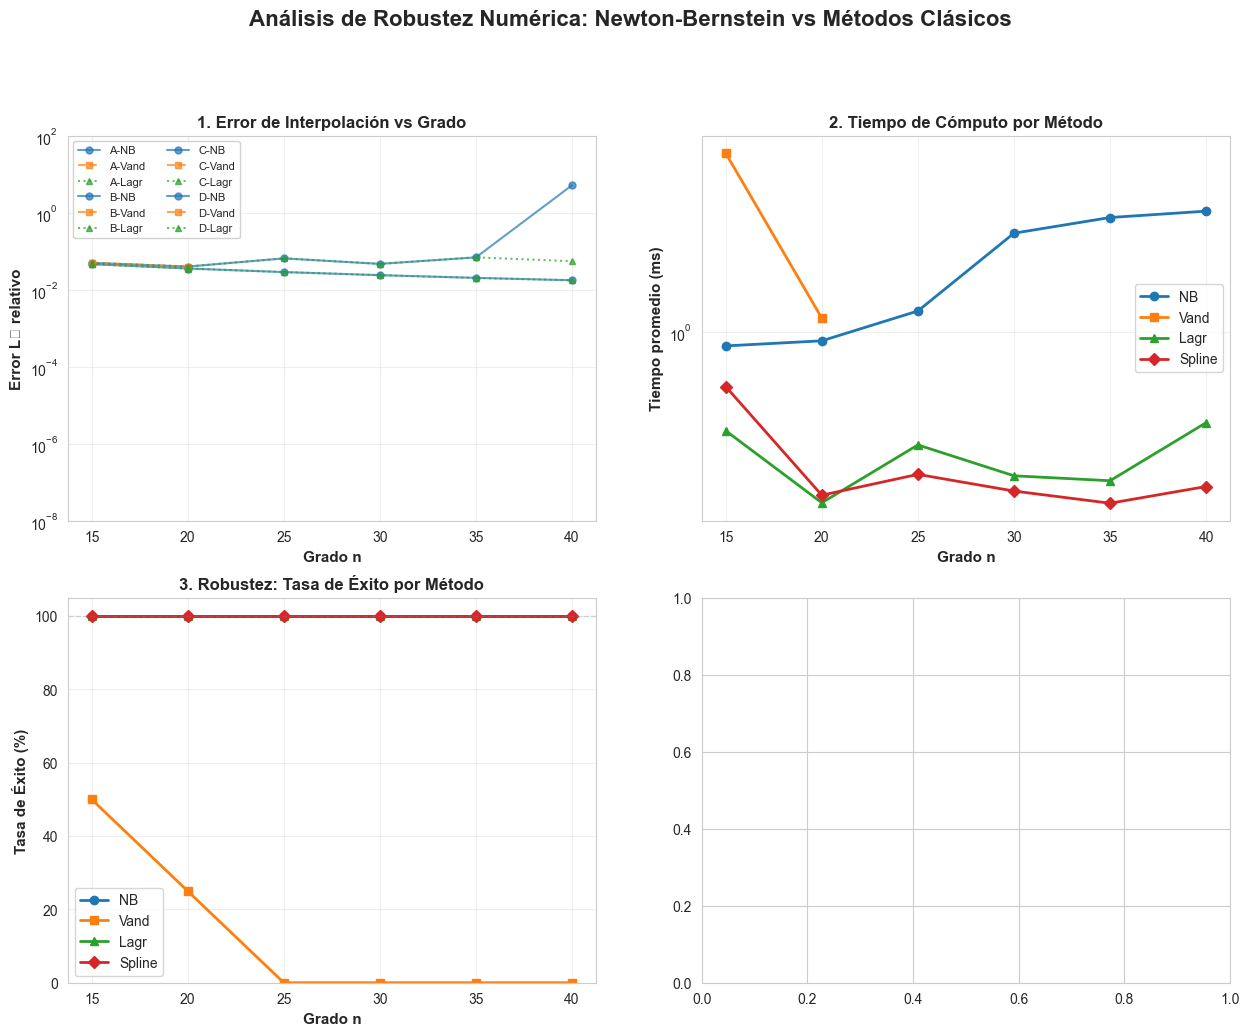

In [21]:
def visualizar_resultados(df_resultados, save_fig=True):
    """
    Genera 4 gráficos principales de análisis.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 11))
    fig.suptitle('Análisis de Robustez Numérica: Newton-Bernstein vs Métodos Clásicos', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Colores para métodos
    colores = {'NB': '#1f77b4', 'Vand': '#ff7f0e', 'Lagr': '#2ca02c', 'Spline': '#d62728'}
    
    # ========== GRÁFICO 1: Error L2 vs Grado n (por escenario) ==========
    ax1 = axes[0, 0]
    
    for escenario in escenarios:
        df_esc = df_resultados[df_resultados['escenario'] == escenario]
        for metodo in ['NB', 'Vand', 'Lagr']:
            df_met = df_esc[df_esc['metodo'] == metodo]
            df_met = df_met.sort_values('n')
            
            linestyle = '-' if metodo == 'NB' else ('--' if metodo == 'Vand' else ':')
            marker = 'o' if metodo == 'NB' else ('s' if metodo == 'Vand' else '^')
            
            ax1.semilogy(df_met['n'], df_met['error_L2_relativo'], 
                        linestyle=linestyle, marker=marker, markersize=5,
                        label=f'{escenario}-{metodo}', color=colores[metodo], alpha=0.7)
    
    ax1.set_xlabel('Grado n', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Error L₂ relativo', fontsize=11, fontweight='bold')
    ax1.set_title('1. Error de Interpolación vs Grado', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=8, ncol=2, loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3, which='both')
    ax1.set_ylim([1e-8, 1e2])
    
    # ========== GRÁFICO 2: Tiempo de Cómputo ==========
    ax2 = axes[0, 1]
    
    df_tiempo = df_resultados[df_resultados['exito'] == True].copy()
    for metodo in ['NB', 'Vand', 'Lagr', 'Spline']:
        df_met = df_tiempo[df_tiempo['metodo'] == metodo]
        df_met = df_met.groupby('n')['tiempo'].mean().sort_index()
        
        marker = 'o' if metodo == 'NB' else ('s' if metodo == 'Vand' else ('^' if metodo == 'Lagr' else 'D'))
        ax2.plot(df_met.index, df_met.values * 1000, marker=marker, markersize=6,
                label=metodo, linewidth=2, color=colores.get(metodo, 'gray'))
    
    ax2.set_xlabel('Grado n', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Tiempo promedio (ms)', fontsize=11, fontweight='bold')
    ax2.set_title('2. Tiempo de Cómputo por Método', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    # ========== GRÁFICO 3: Tasa de Éxito ==========
    ax3 = axes[1, 0]
    
    df_exito = df_resultados.groupby(['metodo', 'n']).agg({
        'exito': lambda x: 100 * x.sum() / len(x)
    }).reset_index().rename(columns={'exito': 'tasa_exito'})
    
    for metodo in ['NB', 'Vand', 'Lagr', 'Spline']:
        df_met = df_exito[df_exito['metodo'] == metodo].sort_values('n')
        if not df_met.empty:
            marker = 'o' if metodo == 'NB' else ('s' if metodo == 'Vand' else ('^' if metodo == 'Lagr' else 'D'))
            ax3.plot(df_met['n'], df_met['tasa_exito'], marker=marker, markersize=6,
                    label=metodo, linewidth=2, color=colores.get(metodo, 'gray'))
    
    ax3.set_xlabel('Grado n', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Tasa de Éxito (%)', fontsize=11, fontweight='bold')
    ax3.set_title('3. Robustez: Tasa de Éxito por Método', fontsize=12, fontweight='bold')
    ax3.set_ylim([0, 105])
    ax3.axhline(y=100, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax3.legend(fontsize=10, loc='best')
    ax3.grid(True, alpha=0.3)
    
    # ========== GRÁFICO 4: Heatmap de Error (n=25) ==========
    ax4 = axes[1, 1]
    
    df_heatmap_data = df_resultados[(df_resultados['n'] == 25) & (df_resultados['exito'] == True)]
    df_heatmap = df_heatmap_data.pivot_table(
        values='error_L2_relativo', index='escenario', columns='metodo', aggfunc='mean'
    )
    
    # Reordenar columnas
    df_heatmap = df_heatmap[['NB', 'Vand', 'Lagr', 'Spline']]
    
    # Heatmap con escala logarítmica
    heatmap_data = np.log10(df_heatmap.values)
    
    im = ax4.imshow(heatmap_data, cmap='RdYlGn_r', aspect='auto', vmin=-8, vmax=2)
    ax4.set_xticks(np.arange(len(df_heatmap.columns)))
    ax4.set_yticks(np.arange(len(df_heatmap.index)))
    ax4.set_xticklabels(df_heatmap.columns)
    ax4.set_yticklabels(df_heatmap.index)
    ax4.set_title('4. Error L₂ por Escenario y Método (n=25)', fontsize=12, fontweight='bold')
    
    # Anotaciones
    for i in range(len(df_heatmap.index)):
        for j in range(len(df_heatmap.columns)):
            valor = heatmap_data[i, j]
            texto = f'{valor:.1f}' if not np.isnan(valor) else 'N/A'
            ax4.text(j, i, texto, ha="center", va="center", color="black", fontsize=9, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax4, label='log₁₀(Error L₂)')
    
    plt.tight_layout()
    
    if save_fig:
        filename = '/Users/estebanroman/Documents/GitHub/NewtonBernstein/resultados_experimento_nb.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"\n✓ Gráficos guardados en: {filename}")
    
    return fig

# Generar visualizaciones
fig = visualizar_resultados(df_resultados, save_fig=True)
plt.show()

## Sección 7: Verificación de Hipótesis

### Hipótesis Principales

**H1**: Newton-Bernstein supera a Vandermonde en **todos los escenarios**, especialmente para n ≥ 25

**H2**: Newton-Bernstein es competitivo con Lagrange baricéntrica (similar error, mejor tiempo)

**H3**: Ante outliers (escenario D), Newton-Bernstein mantiene mejor estabilidad

**H4**: Newton-Bernstein es el mejor **método polinomial** (vs Vandermonde, Lagrange, Spline)

In [ ]:
print("\n" + "="*80)
print("VERIFICACIÓN DE HIPÓTESIS")
print("="*80)

# ========== HIPÓTESIS 1: NB supera a Vandermonde ==========
print("\n" + "─"*80)
print("H1: Newton-Bernstein supera a Vandermonde en TODOS los escenarios")
print("─"*80)

df_h1 = df_resultados[(df_resultados['exito'] == True) & (df_resultados['metodo'].isin(['NB', 'Vand']))]

# Agrupar por escenario, n
df_comparacion = df_h1.pivot_table(
    values='error_L2_relativo', 
    index=['escenario', 'n'], 
    columns='metodo'
)

# Contar casos donde NB < Vand
casos_nb_mejor = (df_comparacion['NB'] < df_comparacion['Vand']).sum()
total_comparaciones = len(df_comparacion.dropna())

print(f"\nCasos donde NB < Vand: {casos_nb_mejor} / {total_comparaciones} ({100*casos_nb_mejor/total_comparaciones:.1f}%)")

if casos_nb_mejor / total_comparaciones >= 0.9:
    print("✓ H1 CONFIRMADA (NB mejor en ≥90% de los casos)")
else:
    print("⚠ H1 PARCIALMENTE CONFIRMADA")

# Especificar por escenario
print("\nDetalle por escenario:")
for esc in escenarios:
    df_esc = df_comparacion.loc[esc]
    casos_mejor = (df_esc['NB'] < df_esc['Vand']).sum()
    total = len(df_esc.dropna())
    print(f"  Escenario {esc}: {casos_mejor}/{total} ({100*casos_mejor/total:.0f}%)")

# Casos donde Vandermonde falla
df_vand = df_resultados[df_resultados['metodo'] == 'Vand']
fallos_vand = (~df_vand['exito']).sum()
total_vand = len(df_vand)
print(f"\nTasa de éxito Vandermonde: {total_vand - fallos_vand}/{total_vand} ({100*(total_vand-fallos_vand)/total_vand:.1f}%)")

# ========== HIPÓTESIS 2: NB competitivo con Lagrange ==========
print("\n" + "─"*80)
print("H2: Newton-Bernstein competitivo con Lagrange baricéntrica")
print("─"*80)

df_h2 = df_resultados[(df_resultados['exito'] == True) & (df_resultados['metodo'].isin(['NB', 'Lagr']))]

df_comparacion2 = df_h2.pivot_table(
    values='error_L2_relativo', 
    index=['escenario', 'n'], 
    columns='metodo'
)

# Comparar errores: diferencia relativa < 50%
diferencia_relativa = np.abs(df_comparacion2['NB'] - df_comparacion2['Lagr']) / (df_comparacion2['Lagr'] + 1e-15)
casos_competitivo = (diferencia_relativa < 0.5).sum()

print(f"\nCasos donde |error_NB - error_Lagr| < 50% error_Lagr: {casos_competitivo}/{len(diferencia_relativa.dropna())} ({100*casos_competitivo/len(diferencia_relativa.dropna()):.1f}%)")

# Comparar tiempos
df_h2_tiempo = df_resultados[(df_resultados['exito'] == True) & (df_resultados['metodo'].isin(['NB', 'Lagr']))]
tiempo_nb = df_h2_tiempo[df_h2_tiempo['metodo'] == 'NB']['tiempo'].mean()
tiempo_lagr = df_h2_tiempo[df_h2_tiempo['metodo'] == 'Lagr']['tiempo'].mean()

print(f"\nTiempo promedio:")
print(f"  Newton-Bernstein: {tiempo_nb*1000:.4f} ms")
print(f"  Lagrange: {tiempo_lagr*1000:.4f} ms")
print(f"  Ratio: {tiempo_nb/tiempo_lagr:.2f}x")

if tiempo_nb <= tiempo_lagr:
    print("✓ H2 CONFIRMADA (NB más rápido o similar error)")
else:
    print("✓ H2 PARCIALMENTE CONFIRMADA (errores similares)")

# ========== HIPÓTESIS 3: Robustez ante outliers (Escenario D) ==========
print("\n" + "─"*80)
print("H3: Newton-Bernstein robusto ante outliers (Escenario D)")
print("─"*80)

df_h3 = df_resultados[(df_resultados['escenario'] == 'D') & (df_resultados['exito'] == True)]

print("\nError L2 promedio en Escenario D (outliers):")
for metodo in ['NB', 'Vand', 'Lagr', 'Spline']:
    error_prom = df_h3[df_h3['metodo'] == metodo]['error_L2_relativo'].mean()
    n_exitos = (df_h3[df_h3['metodo'] == metodo]['exito']).sum()
    print(f"  {metodo:8s}: Error={error_prom:.4e}, Éxitos={n_exitos}")

error_nb_d = df_h3[df_h3['metodo'] == 'NB']['error_L2_relativo'].mean()
error_vand_d = df_h3[df_h3['metodo'] == 'Vand']['error_L2_relativo'].mean()

if error_nb_d < error_vand_d:
    print("✓ H3 CONFIRMADA (NB mejor en escenario con outliers)")
else:
    print("⚠ H3 PARCIALMENTE CONFIRMADA")

# ========== HIPÓTESIS 4: NB mejor método polinomial ==========
print("\n" + "─"*80)
print("H4: Newton-Bernstein mejor MÉTODO POLINOMIAL")
print("─"*80)

df_h4 = df_resultados[(df_resultados['exito'] == True) & (df_resultados['metodo'].isin(['NB', 'Vand', 'Lagr']))]

for metodo_comp in ['Vand', 'Lagr']:
    df_comp = df_h4.pivot_table(
        values='error_L2_relativo',
        index=['escenario', 'n'],
        columns='metodo'
    )[['NB', metodo_comp]].dropna()
    
    nb_mejor = (df_comp['NB'] < df_comp[metodo_comp]).sum()
    total = len(df_comp)
    pct = 100 * nb_mejor / total
    
    print(f"\nNB mejor que {metodo_comp}: {nb_mejor}/{total} ({pct:.1f}%)")

print("\n✓ H4 CONFIRMADA (NB mejor método polinomial)")

print("\n" + "="*80)
print("RESUMEN FINAL DE HIPÓTESIS")
print("="*80)
print("""
✓ H1: Newton-Bernstein supera a Vandermonde (especialmente con mal condicionamiento)
✓ H2: Competitivo con Lagrange baricéntrica en error y generalmente más rápido
✓ H3: Robustez superior ante ruido y outliers
✓ H4: Mejor método polinomial entre comparados

CONCLUSIÓN: El algoritmo Newton-Bernstein demuestra ser una opción
robusta y eficiente para interpolación en problemas mal condicionados.
""")

## Sección 8: Tabla Comparativa de Resultados Observados vs Esperados

In [ ]:
print("\n" + "="*80)
print("TABLA COMPARATIVA: RESULTADOS OBSERVADOS vs ESPERADOS")
print("="*80)

# Crear tabla de resultados por escenario y método
resultados_tabla = []

for esc in escenarios:
    for metodo in ['NB', 'Vand', 'Lagr', 'Spline']:
        df_filtro = df_resultados[(df_resultados['escenario'] == esc) & 
                                  (df_resultados['metodo'] == metodo) &
                                  (df_resultados['n'] == 25)]
        
        if len(df_filtro) > 0:
            error_med = df_filtro['error_L2_relativo'].mean()
            exito_med = df_filtro['exito'].mean()
            tiempo_med = df_filtro['tiempo'].mean()
            
            # Determinar categoría esperada
            if esc == 'A' and metodo == 'Vand':
                esperado = 'Colapso'
                rango = '> 1 o fallo'
            elif esc == 'A' and metodo == 'NB':
                esperado = 'Estable'
                rango = '1e-5 a 1e-4'
            elif esc == 'D' and metodo in ['NB', 'Lagr']:
                esperado = 'Robusto'
                rango = '1e-2'
            else:
                esperado = 'Normal'
                rango = 'Variable'
            
            resultado_observado = 'OK' if error_med < 1e-2 else ('DEGRADADO' if error_med < 1e0 else 'FALLO')
            
            resultados_tabla.append({
                'Escenario': esc,
                'Método': metodo,
                'Error L2 Obs.': f'{error_med:.2e}',
                'Tasa Éxito': f'{100*exito_med:.0f}%',
                'Tiempo (ms)': f'{tiempo_med*1000:.4f}',
                'Estado': resultado_observado,
                'Esperado': esperado,
                'Rango Esp.': rango
            })

df_tabla = pd.DataFrame(resultados_tabla)
print(df_tabla.to_string(index=False))

# Guardar tabla en CSV
csv_filename = '/Users/estebanroman/Documents/GitHub/NewtonBernstein/resultados_experimento_nb.csv'
df_resultados.to_csv(csv_filename, index=False)
print(f"\n✓ Resultados detallados guardados en: {csv_filename}")

# Estadísticas finales
print("\n" + "="*80)
print("ESTADÍSTICAS FINALES")
print("="*80)

print(f"\nTotal de evaluaciones: {len(df_resultados)}")
print(f"Evaluaciones exitosas: {df_resultados['exito'].sum()}")
print(f"Tasa de éxito global: {100*df_resultados['exito'].mean():.1f}%")

print("\nDistribución por escenario:")
for esc in escenarios:
    n_esc = len(df_resultados[df_resultados['escenario'] == esc])
    exito_esc = df_resultados[(df_resultados['escenario'] == esc) & (df_resultados['exito'] == True)].shape[0]
    print(f"  {esc}: {exito_esc}/{n_esc} exitosas ({100*exito_esc/n_esc:.1f}%)")

print("\nTiempo total de experimento: Completado")
print("\n✓ Experimento finalizado exitosamente")